# Machine Learning with Broad Stock Market Timeseries - a SARIMA Rollercoaster

<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![]()


## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

You'll need access to [analysis_utils](./analysis_utils.py) library for common functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import load_ticker_prices_ts_df, load_ticker_ts_df

os.getcwd()

Running Local...


'c:\\Users\\adamd\\workspace\\quant_research'

# Data Collection and Preprocessing

Collect market time series data (like stock prices, trading volumes, etc.).
Clean the data to handle missing values, outliers, or anomalies.
Ensure the data is in a time series format, typically with a timestamp.

In [2]:
START_DATE = "2013-01-01"
END_DATE = "2023-12-31"
DATA_DIR = "data"

# Ensure the data directory exists
os.makedirs(DATA_DIR, exist_ok=True)

# Tickers dictionary
tickers = {
    "SP5": "^GSPC",  # S&P 500
    "VTW": "VT",  # Vanguard Total World Stock ETF
    "VIX": "^VIX",  # CBOE Volatility Index
    "10YTT": "^TNX",  # 10 Year Treasury Note Yield
    "VEU": "VEU",  # Vanguard FTSE All-World ex-US ETF
}

# DataFrames for each ticker
dataframes = {}
for symbol, ticker in tickers.items():
    cached_file_path = f"{DATA_DIR}/{symbol}-{END_DATE}.pkl"

    try:
        if os.path.exists(cached_file_path):
            df = pd.read_pickle(cached_file_path)
        else:
            df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
            df.to_pickle(cached_file_path)
        dataframes[symbol] = df
    except Exception as e:  # Catching a broader range of exceptions
        print(f"Error with {symbol}: {e}")

# Accessing individual dataframes
sp500_df = dataframes.get("SP5")
vtw_df = dataframes.get("VTW")
vix_df = dataframes.get("VIX")
t10ytt_df = dataframes.get("10YTT")
veu_df = dataframes.get("VEU")

# Example: Displaying the last 5 rows of VEU data
vtw_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,102.250000,102.510002,101.849998,102.220001,102.220001,1975100
2023-12-26,102.360001,102.919998,102.339996,102.730003,102.730003,1221900
2023-12-27,102.800003,103.110001,102.760002,103.029999,103.029999,1414500
2023-12-28,103.180000,103.400002,103.029999,103.099998,103.099998,2707800
2023-12-29,103.150002,103.290001,102.629997,102.879997,102.879997,2336200


# Exploratory Data Analysis

Visualize the data to identify patterns, trends, seasonality, and cyclical behaviors.
Compute summary statistics to understand data distribution and variability.

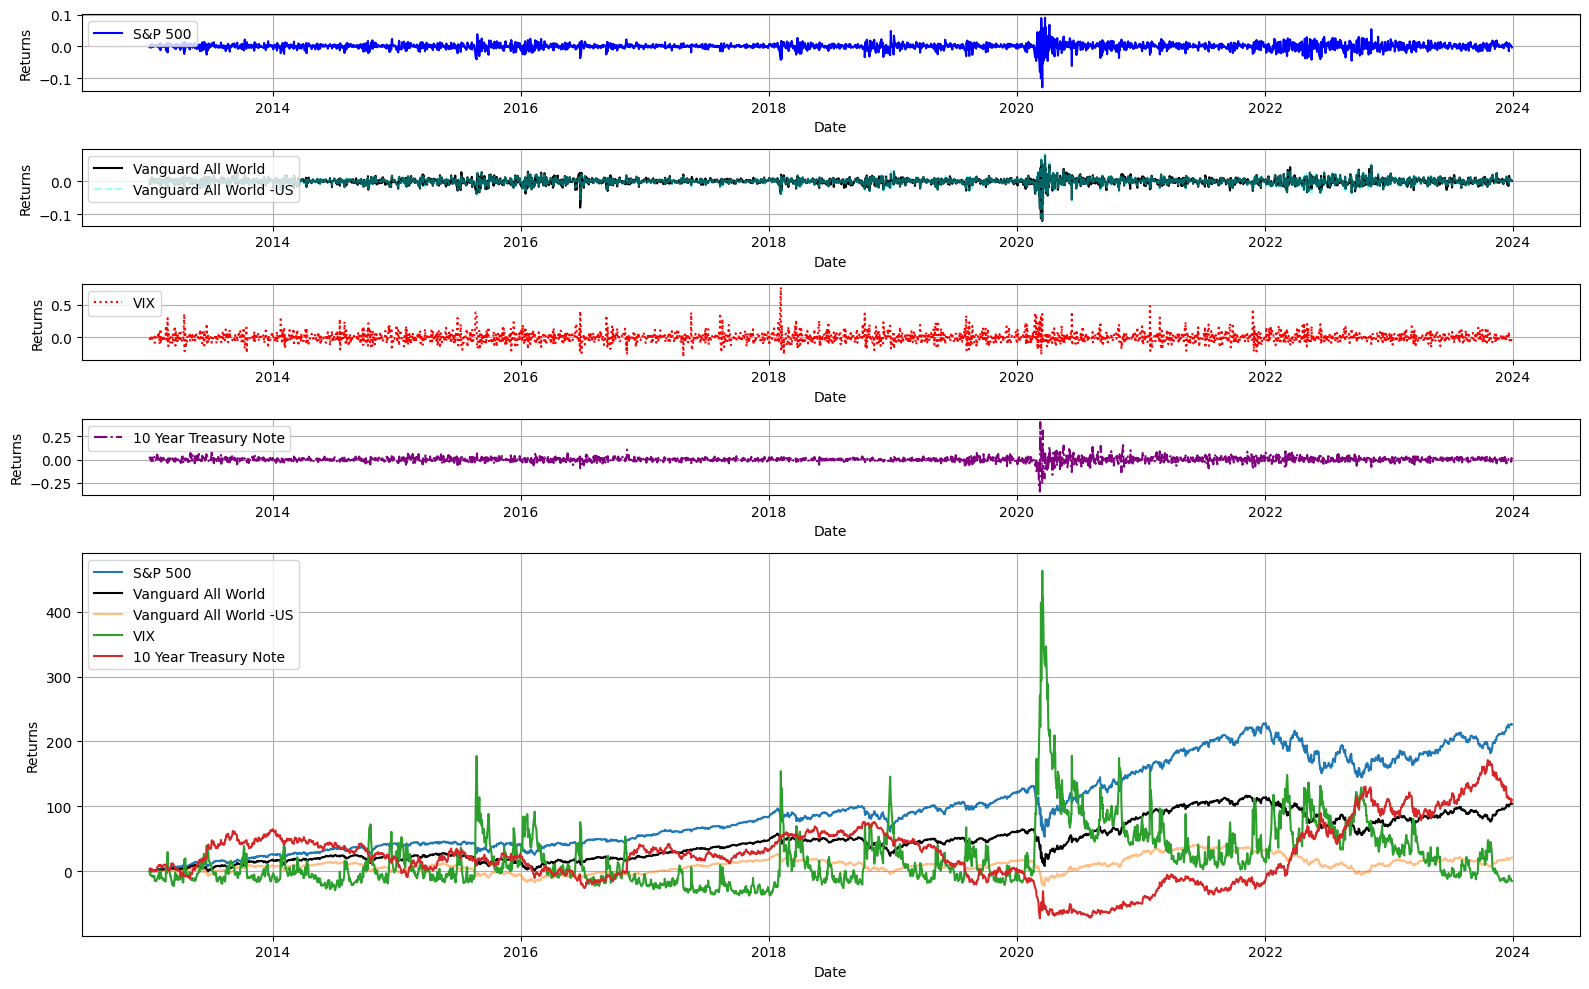

In [3]:
sp500_lr = np.log(sp500_df["Close"] / sp500_df["Close"].shift(1))
veu_lr = np.log(veu_df["Close"] / veu_df["Close"].shift(1))
vix_lr = np.log(vix_df["Close"] / vix_df["Close"].shift(1))
tnx_lr = np.log(t10ytt_df["Close"] / t10ytt_df["Close"].shift(1))
vtw_lr = np.log(vtw_df["Close"] / vtw_df["Close"].shift(1))

sp500_pr = ((1 + sp500_df["Close"].pct_change()).cumprod() - 1) * 100
veu_pr = ((1 + veu_df["Close"].pct_change()).cumprod() - 1) * 100
vix_pr = ((1 + vix_df["Close"].pct_change()).cumprod() - 1) * 100
tnx_pr = ((1 + t10ytt_df["Close"].pct_change()).cumprod() - 1) * 100
vtw_pr = ((1 + vtw_df["Close"].pct_change()).cumprod() - 1) * 100

fig, ax = plt.subplots(
    5, 1, figsize=(16, 10), gridspec_kw={"height_ratios": (1, 1, 1, 1, 5)}
)

ax[0].plot(sp500_lr, label="S&P 500", linestyle="-", color="blue")
ax[1].plot(veu_lr, label="Vanguard All World", linestyle="-", color="black", alpha=1)
ax[1].plot(
    vtw_lr, label="Vanguard All World -US", linestyle="--", color="cyan", alpha=0.4
)
ax[2].plot(vix_lr, label="VIX", linestyle=":", color="red")
ax[3].plot(tnx_lr, label="10 Year Treasury Note", linestyle="-.", color="purple")
ax[4].plot(sp500_pr, label="S&P 500")
ax[4].plot(vtw_pr, label="Vanguard All World", color="black")
ax[4].plot(veu_pr, label="Vanguard All World -US", alpha=0.5)
ax[4].plot(vix_pr, label="VIX")
ax[4].plot(tnx_pr, label="10 Year Treasury Note")
for a in ax:
    a.set_xlabel("Date")
    a.set_ylabel("Returns")
    a.legend(loc="upper left")
    a.grid(True)

plt.tight_layout()


plt.show()

Let's start with a timeseries definition.

A timeseries is comprised of 4 components, in a multiplicative timeseries (where the components are interdependant) it is visualized as follows:

$Y(t)=T(t)×S(t)×C(t)×\epsilon(t)$

Where $T$ is the trend, $S$ is the seasonal trend, $C$ is the cyclical trend and $\epsilon$ is noise in any point in time $t$. The additive version (no dependant components) would substitute the operator to $+$.

We know its a seasonal and probably not stationary timeseries - we verify these assumptions below using statsmodels's [seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) api:


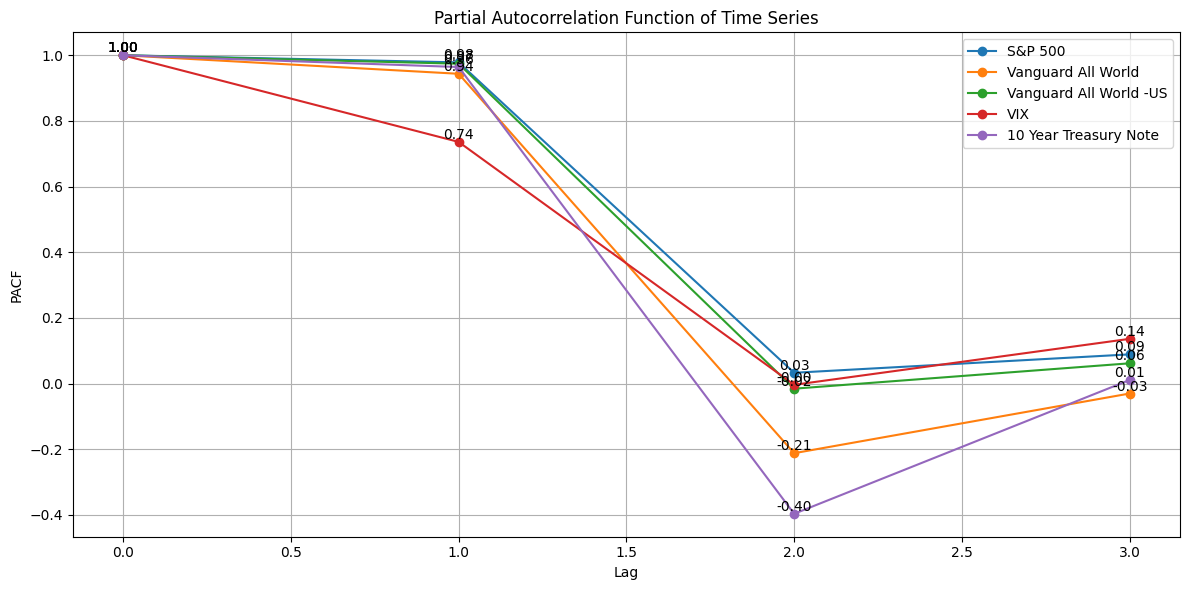

In [12]:
from statsmodels.tsa.stattools import pacf

time_series_list = [sp500_df, veu_df, vtw_df, vix_df, t10ytt_df]
SAMPLE_FREQ = "1M"
names = [
    "S&P 500",
    "Vanguard All World",
    "Vanguard All World -US",
    "VIX",
    "10 Year Treasury Note",
]
LAGS = 3

plt.figure(figsize=(12, 6))
for ts, name in zip(time_series_list, names):
    ts_data = ts["Close"].resample(SAMPLE_FREQ).mean().dropna()
    pacf_values = pacf(ts_data, nlags=LAGS)
    lags = range(len(pacf_values))
    plt.plot(lags, pacf_values, marker='o', label=name)  # Adding markers
    for lag, value in zip(lags, pacf_values):
        plt.text(lag, value, f'{value:.2f}', ha='center', va='bottom')  # Adding text labels

plt.title("Partial Autocorrelation Function of Time Series")
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.grid(True)  # Adding grid
plt.legend()
plt.tight_layout()
plt.show()

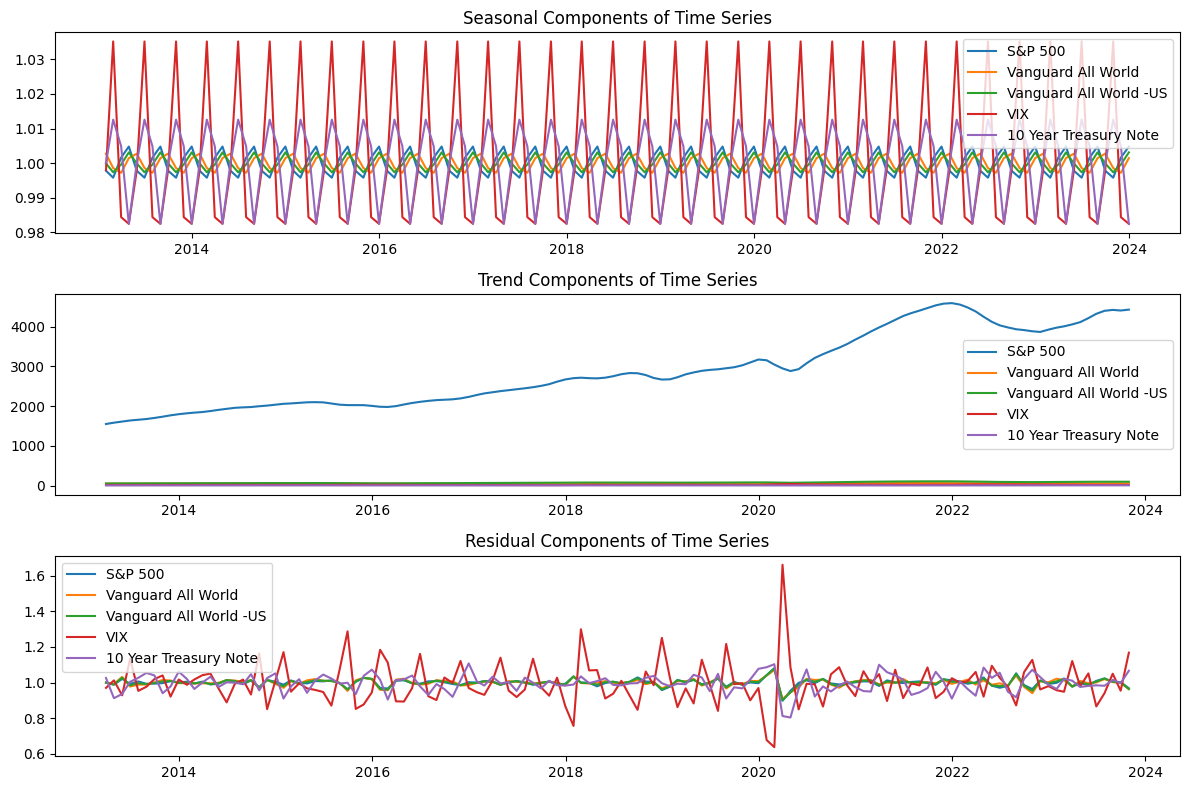

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

time_series_list = [sp500_df, veu_df, vtw_df, vix_df, t10ytt_df]
names = [
    "S&P 500",
    "Vanguard All World",
    "Vanguard All World -US",
    "VIX",
    "10 Year Treasury Note",
]

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
for ts, name in zip(time_series_list, names):
    ts_data = ts["Close"].resample(SAMPLE_FREQ).mean().dropna()
    result = seasonal_decompose(ts_data, model="multiplicative", period=4)
    plt.plot(result.seasonal, label=name)
plt.title("Seasonal Components of Time Series")
plt.legend()
plt.subplot(3, 1, 2)
for ts, name in zip(time_series_list, names):
    ts_data = ts["Close"].resample(SAMPLE_FREQ).mean().dropna()
    result = seasonal_decompose(ts_data, model="multiplicative", period=4)
    plt.plot(result.trend, label=name)
plt.title("Trend Components of Time Series")
plt.legend()
plt.subplot(3, 1, 3)
for ts, name in zip(time_series_list, names):
    ts_data = ts["Close"].resample(SAMPLE_FREQ).mean().dropna()
    result = seasonal_decompose(ts_data, model="multiplicative", period=4)
    plt.plot(result.resid, label=name)
plt.title("Residual Components of Time Series")
plt.legend()
plt.tight_layout()
plt.show()


# Stationarity Testing

Use tests like Augmented Dickey-Fuller (ADF) test to check if the time series is stationary.
Non-stationary data might need differencing or transformation.

Model Identification for SARIMA:

Determine the SARIMA model parameters (p, d, q) x (P, D, Q, S):
p and seasonal P for autoregressive terms.
d and seasonal D for differencing order.
q and seasonal Q for moving average terms.
S for the seasonal length.
Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots help in identifying these parameters.

Model Fitting:

Fit the SARIMA model to the data.
Use historical data for training.
Model Validation:

Perform cross-validation, like rolling-forecast origin or time series split.
Compare the model's predictions with the actual data.
Use metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), or Akaike Information Criterion (AIC) for model evaluation.

Incorporating Exogenous Variables (Exog):

Investigate if external factors (like economic indicators, company news, etc.) can be included as exogenous variables.
Check for correlation between exogenous variables and the market data.
Use techniques like Granger Causality Test to examine if exogenous variables provide predictive power.
Forecasting and Analysis:

# Conclusion




![]()

## References

- [YFinance Github](https://github.com/ranaroussi/yfinance)
- [Vanguard All World excluding US](https://investor.vanguard.com/investment-products/etfs/profile/veu)


## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.